In [52]:
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.stats import norm, gaussian_kde
from scipy.integrate import simpson, cumulative_trapezoid
from scipy.interpolate import interp1d, interpolate
from pandas.tseries.offsets import CustomBusinessDay, MonthEnd
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import os
from multiprocessing import Process
import pickle
from datetime import datetime
from concurrent.futures import ProcessPoolExecutor
from joblib import Parallel, delayed

from simulation_classes_new_9 import (RNDAnalyzer, RNDVisualizer, OptionSimulator, 
                              HistoricalDensityCalculator, ResultsVisualizer)

from matplotlib.gridspec import GridSpec

from scipy import integrate
from scipy.interpolate import interp1d
import scipy.io as sio



## Guide

1. Set the "SIMULATION_DIR" in the "Multithreading functions" cell
2. Define all the parameters to run the simulation in the "Multithreading functions" cell
3. Define the "output_path" in the "Dataextraction for R code" cell.
4. Define the "output_dir" in the CDI varaible" cell and change the resulting file name to easily find it - recommendation "BASE_VOLA_JUMP_DATE_NEW_VOLA_SIMUSTART_SIMUEND_00X".
5. Run the "Multiple Simu" or "Single Simu" cell to start the simulation process using the predefined parameters.
6. Load all available simulation sets by running "Available simulations" and chose one file you want to load the data for by running "Load simulation"
7. Run the "Dataextraction for R code" cell to create the cleaned datasets. These sets should be saved in the dir where the R-script is saved.
8. In order to create the MATLAB datasets define the date for which you would like to analyze the CDI EPK and run the code. The .mat files should be safe in the dir where the MATLAB code is saved.


# Mulithreading functions

In [40]:
# Set the directory where simulation results will be saved
SIMULATION_DIR = r"" #SET PATH

def run_single_simulation(params, simulation_name):
   
    S0, mu, base_sigma, r, moneyness_range, n_strikes, start_date, end_date, volatility_changes = params

    simulator = OptionSimulator(S0, mu, base_sigma, r, moneyness_range, n_strikes, 
                                start_date, end_date, volatility_changes)
    
    daily_options, options_unfiltered, deleted_options = simulator.run_simulation()

    rnd_analyzer = RNDAnalyzer(daily_options)
    rnd_analyzer.analyze()
    rnd_analyzer.compile_rnd_data()

    # Density Calculation
    density_calculator = HistoricalDensityCalculator(simulator.prices)

    # Visualization
    visualizer = ResultsVisualizer(simulator, rnd_analyzer, density_calculator, daily_options)

    # save simu data
    simulation_data = {
        'simulator': simulator,
        'daily_options': daily_options,
        'options_unfiltered': options_unfiltered,
        'deleted_options': deleted_options,
        'rnd_analyzer': rnd_analyzer,
        'density_calculator': density_calculator,
        'visualizer': visualizer,
        'volatility_schedule': simulator.volatility_schedule,
        'prices': simulator.prices
    }
    
    # Safe simulation - This enables us to open old simulations.
    file_path = os.path.join(SIMULATION_DIR, f'{simulation_name}.pkl')
    with open(file_path, 'wb') as f:
        pickle.dump(simulation_data, f)
    
    print(f"Simulation {simulation_name} saved")



def run_parallel_simulations():

    # Define base parameters
    S0 = 100                    # Initial stock price
    mu = 0.00                   # Drift
    r = 0.00                    # Risk free rate
    moneyness_range = (0.8, 1.2)# Moneyness range for option simulation
    n_strikes = 20              # Number of strike prices

    # Define specific parameters for each simulation
    base_sigma_1 = 0.2         
    base_sigma_2 = 0.2        
    base_sigma_3 = 0.2         

    # Set timeframes
    start_date_1 = '2015-01-01'
    end_date_1 = '2025-12-31'
    start_date_2 = '2015-01-01'
    end_date_2 = '2025-12-31'
    start_date_3 = '2015-01-01'
    end_date_3 = '2025-12-31'

    # Set vola jumps
    volatility_changes_1 = []
    volatility_changes_2 = []
    volatility_changes_3 = []


    params1 = (S0, mu, base_sigma_1, r, moneyness_range, n_strikes, 
              start_date_1, end_date_1, volatility_changes_1)
    params2 = (S0, mu, base_sigma_2, r, moneyness_range, n_strikes, 
              start_date_2, end_date_2, volatility_changes_2)
    params3 = (S0, mu, base_sigma_3, r, moneyness_range, n_strikes, 
              start_date_3, end_date_3, volatility_changes_3)

    name1 = input("Name of Simulation 1: ")
    name2 = input("Name of Simulation 2: ")
    name3 = input("Name of Simulation 3: ")

    print("Start parallel simulationen...")
    
    # Run simulations simultaneously 4 workers(!)
    Parallel(n_jobs=3)(
        delayed(run_single_simulation)(params, name) 
        for params, name in [(params1, name1), (params2, name2), (params3, name3)]
    )
    
    print("All simulations finished")

# Load simulation dataset
def load_simulation(name):
    with open(os.path.join(SIMULATION_DIR, f'{name}.pkl'), 'rb') as f:
        simulation_data = pickle.load(f)
    
    return (simulation_data['simulator'],
            simulation_data['daily_options'],
            simulation_data['options_unfiltered'],
            simulation_data['deleted_options'],
            simulation_data['rnd_analyzer'],
            simulation_data['density_calculator'],
            simulation_data['visualizer'],
            simulation_data['volatility_schedule'],
            simulation_data['prices'])

# Show all available simulations in DIR
def list_saved_simulations():
    return [f.replace('.pkl', '') for f in os.listdir(SIMULATION_DIR) if f.endswith('.pkl')]



### Single Simu

In [ ]:

""" # Parameter für eine einzelne Simulation
S0 = 100
mu = 0.00
base_sigma = 0.15
r = 0.00
moneyness_range = (0.8, 1.2)
n_strikes = 20
start_date = '2000-01-01'
end_date = '2000-12-31'
volatility_changes = []

params = (S0, mu, base_sigma, r, moneyness_range, n_strikes, 
         start_date, end_date, volatility_changes)

simulation_name = "NAME_OF_SINGLE_SIMU"

run_single_simulation(params, simulation_name) """

### Multiple Simu

In [42]:
run_parallel_simulations()

Start parallel simulationen...
All simulations finished


# Available simulations

In [43]:
print("\nThe following datasets are available:")
print(list_saved_simulations())


The following datasets are available:
['1', '2', '3', '4', '5', '6', 'Constant_BVola_15_2015_2025_001', 'Constant_BVola_15_2015_2025_002', 'Constant_BVola_15_2015_2025_003', 'Constant_BVola_15_2015_2025_004', 'Constant_BVola_15_2015_2025_005', 'Constant_BVola_15_2015_2025_006', 'Constant_BVola_20_2015_2025_001', 'Constant_BVola_20_2015_2025_002', 'Constant_BVola_20_2015_2025_003', 'Constant_Vola_2000_2040_001', 'Constant_Vola_2000_2040_002', 'Constant_Vola_2000_2040_003', 'FINAL1', 'FINAL2', 'FINAL3', 'Future_Jump_01_01_2013_BVola_15_New_30_2000_2025_001', 'Future_Jump_01_01_2013_BVola_15_New_30_2000_2025_002', 'Future_Jump_01_01_2013_BVola_15_New_30_2000_2025_003', 'Future_Jump_01_01_2013_BVola_15_New_30_2000_2025_004', 'Future_Jump_01_01_2013_BVola_15_New_30_2000_2025_005', 'Future_Jump_01_01_2013_BVola_15_New_30_2000_2025_006', 'Future_Jump_01_01_2015_BVola_15_New_30_2000_2020_001', 'Future_Jump_01_01_2015_BVola_15_New_30_2000_2020_002', 'Future_Jump_01_01_2015_BVola_15_New_30_2000

# Load simulation

In [44]:
#Load simulation
sim_name = input("Chose a simulation to load ")
simulator, daily_options, options_unfiltered, deleted_options, \
rnd_analyzer, density_calculator, visualizer, \
volatility_schedule, prices = load_simulation(sim_name)

filtered_options = simulator.option_data
rnd_data = rnd_analyzer.rnd_data

visualizer = ResultsVisualizer(simulator, rnd_analyzer, density_calculator, daily_options)

visualizer.plot_overall_results()



# Chose date for EPK analysis & overall plotting 


Analyzed day: 2020-01-10 00:00:00
Calc HD for 2020-01-10 00:00:00 with tau_day=21, EXP=2020-01-31 00:00:00
Sampling for HD: tau_day=21, S0=81.18806199893626, expiry_date=2020-01-31 00:00:00
Unfiltered Data: 1275 Datapoints
Filtered Data: 1261 Datapoints
MC based on 1240 samples
Used data: 2015-01-02 00:00:00 to 2020-01-10 00:00:00

Analysis for expiry: 2020-01-31 00:00:00
Used tau_day for Returns: 21
HD calculated based on the dates between 2015-01-02 00:00:00 and 2020-01-10 00:00:00


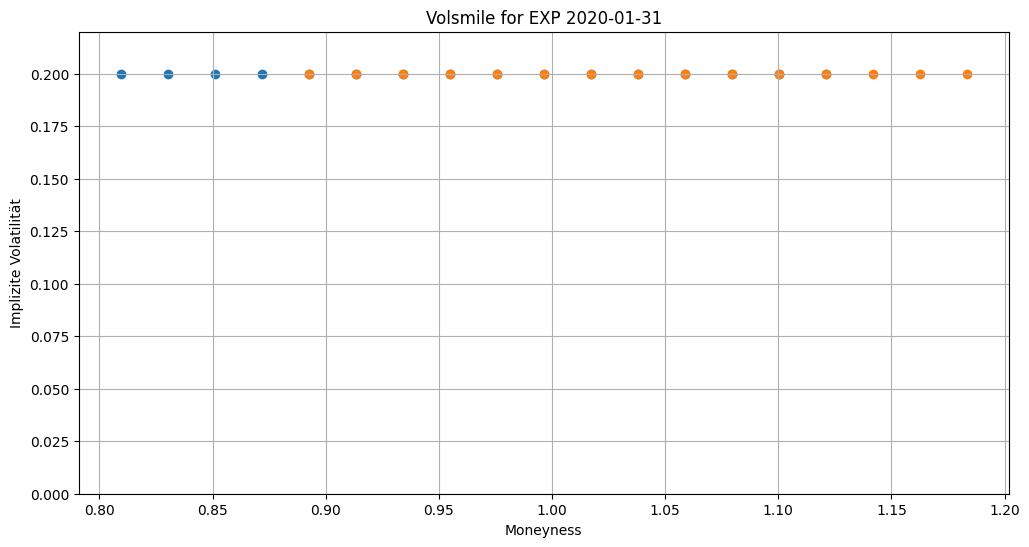

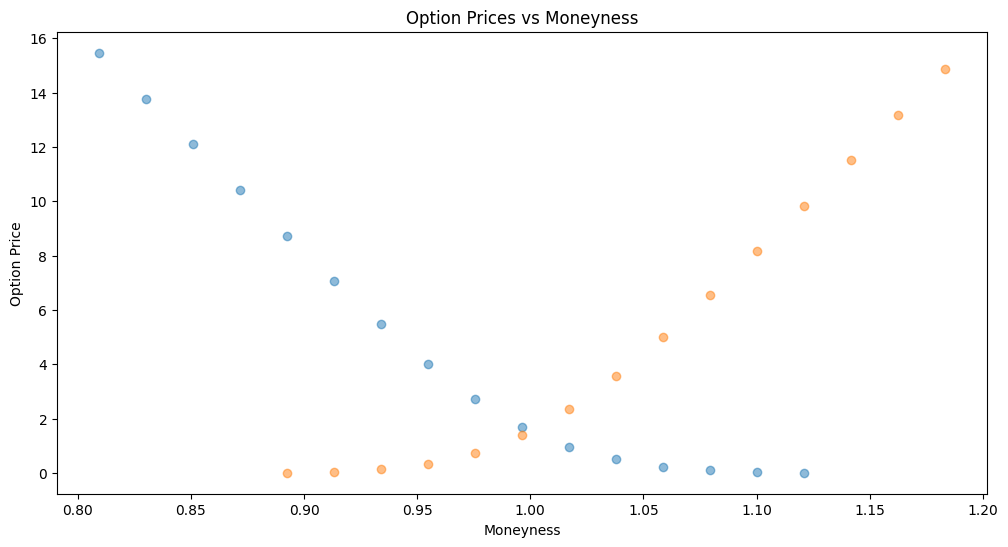

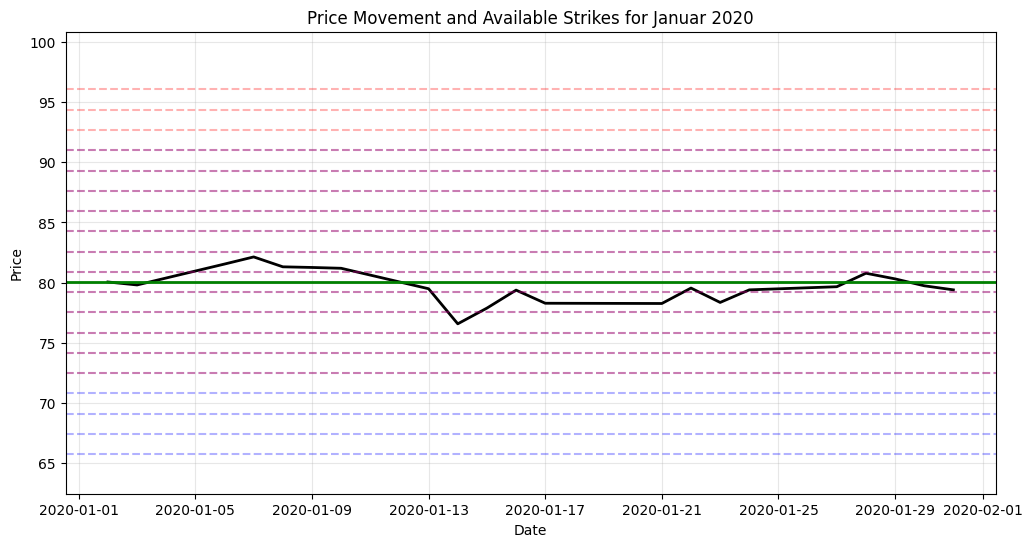

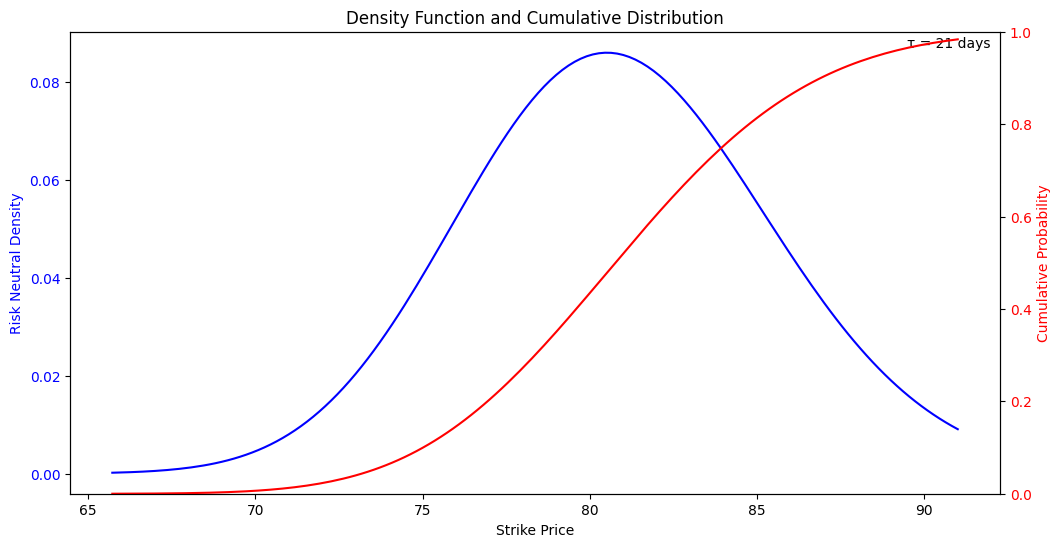

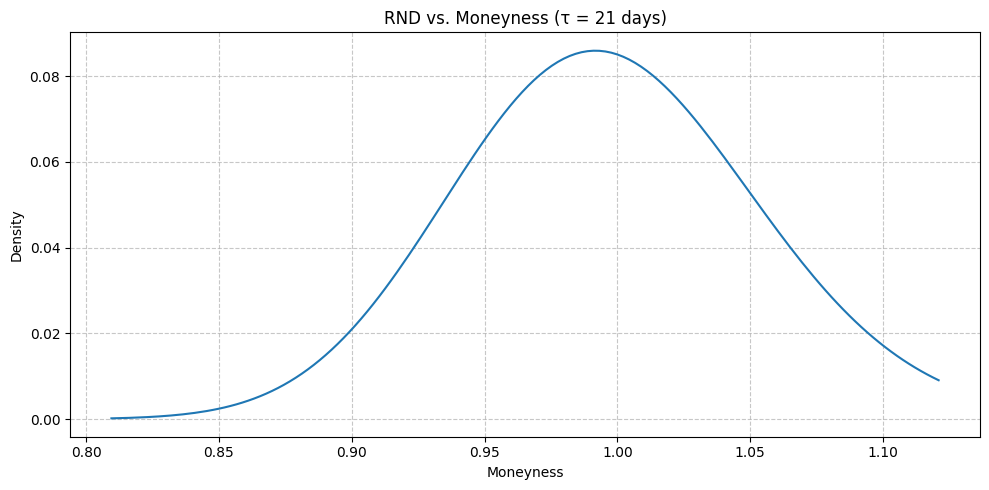

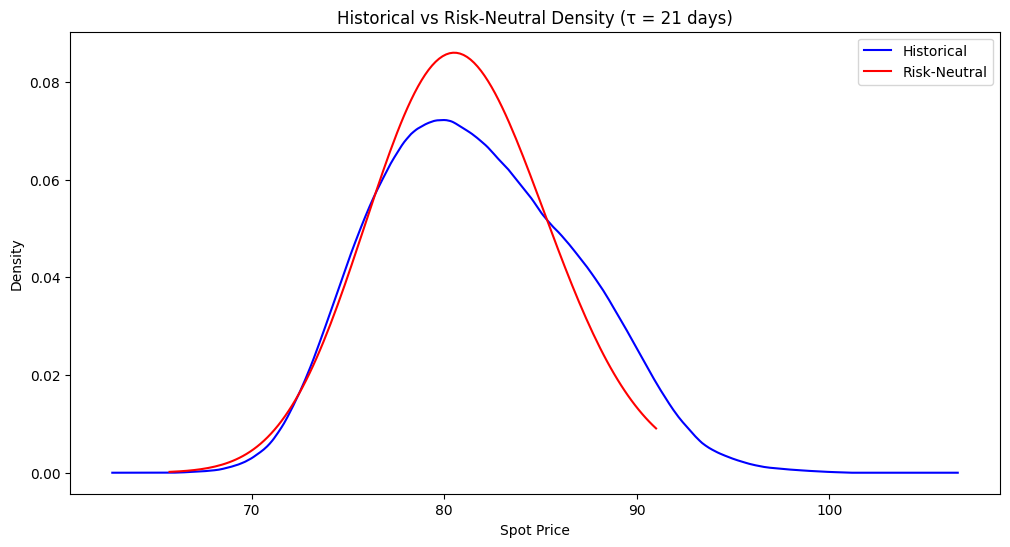

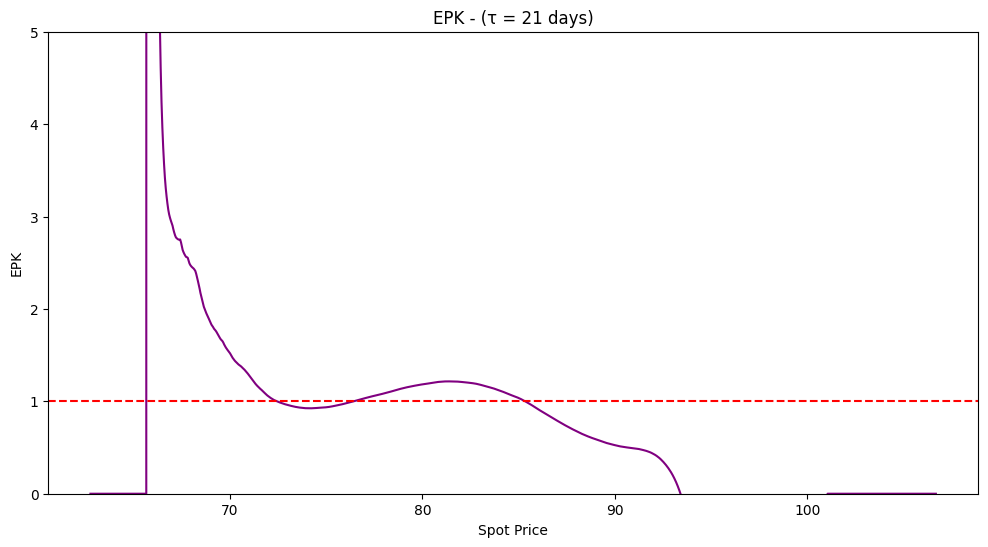

Sampling for HD: tau_day=21, S0=81.18806199893626, expiry_date=2020-01-31 00:00:00
Unfiltered Data: 2755 Datapoints
Filtered Data: 1261 Datapoints
MC based on 1240 samples
Used data: 2015-01-02 00:00:00 to 2020-01-10 00:00:00


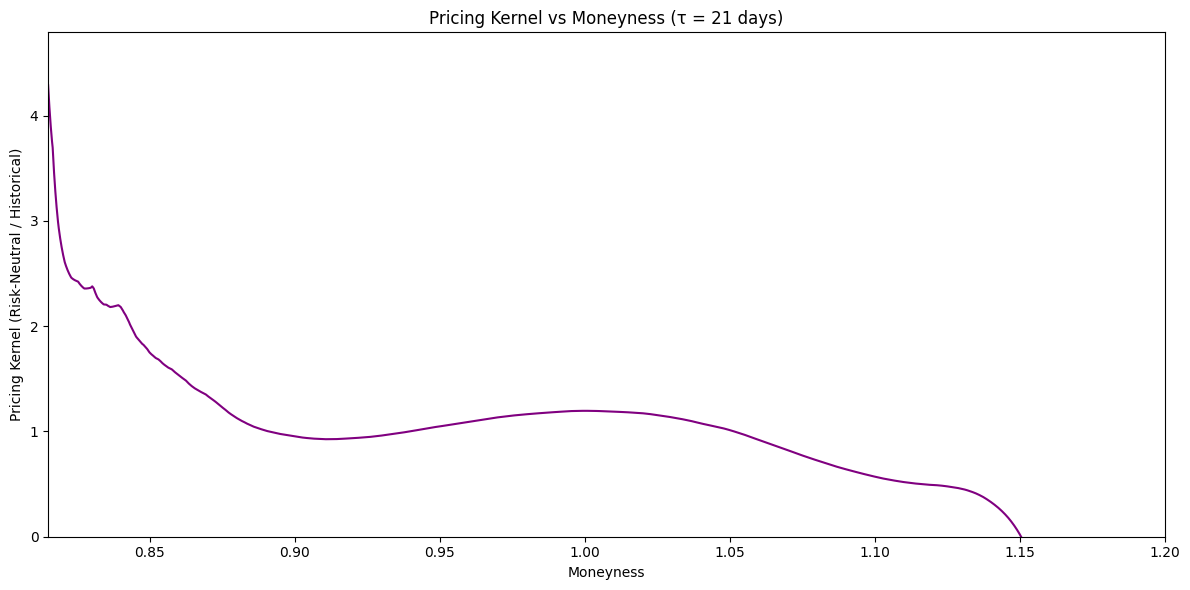

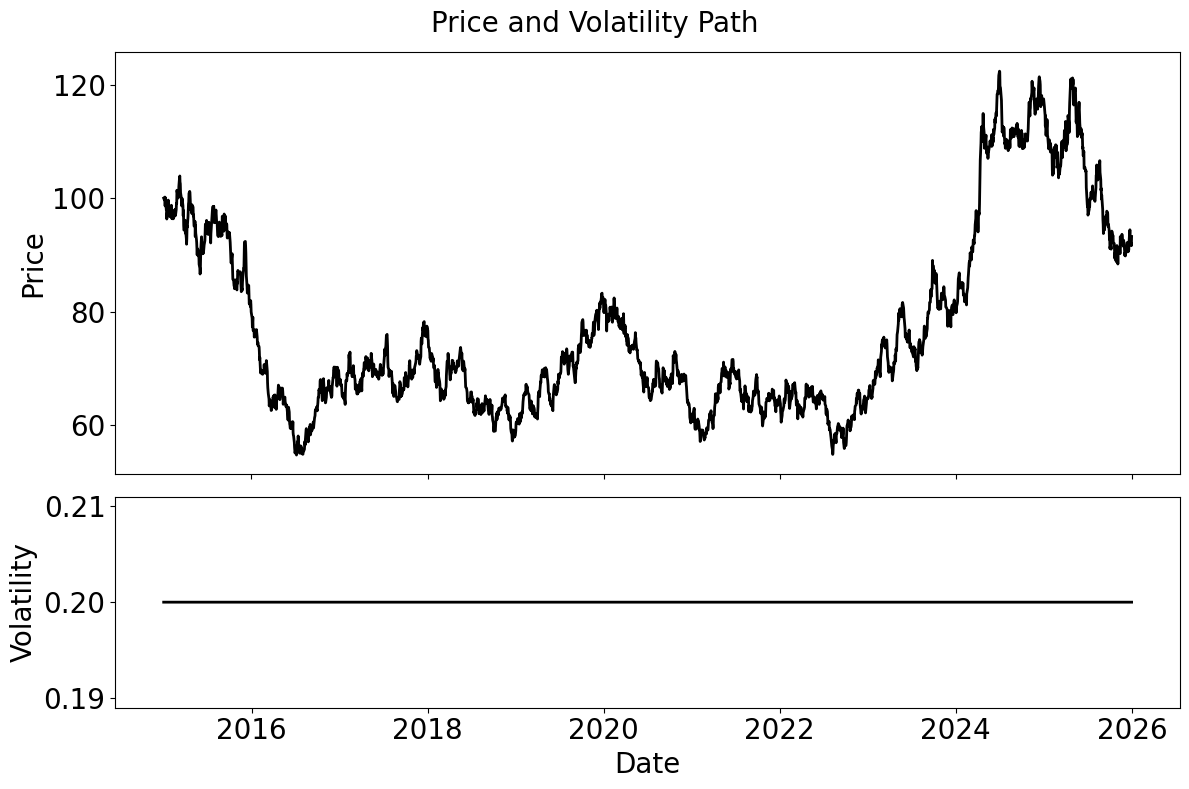

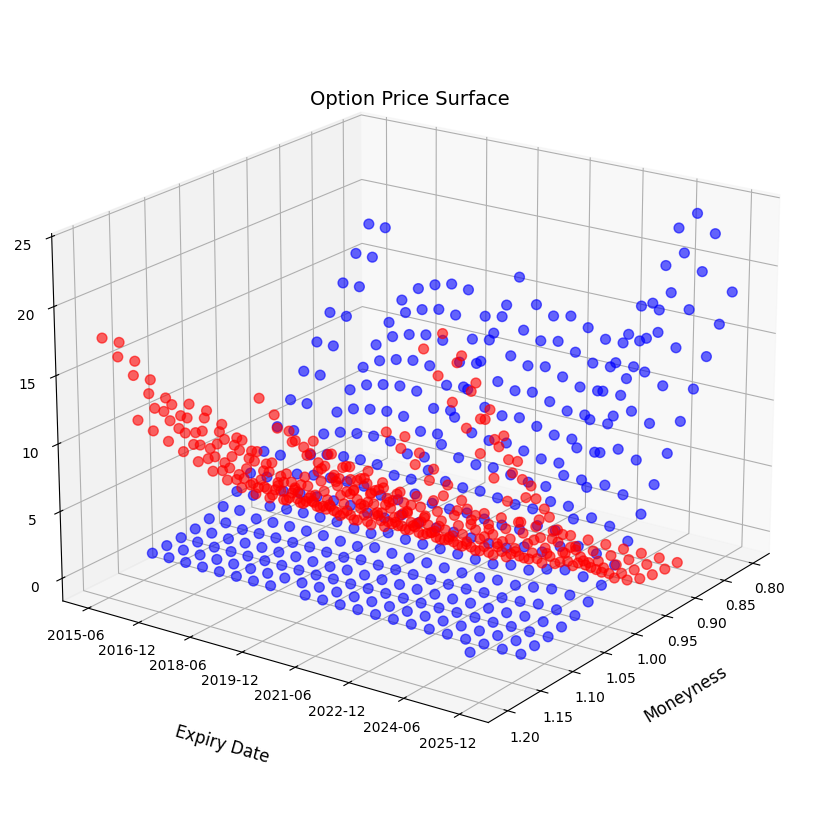

In [54]:
analyzed_day = pd.Timestamp('2020-01-10') #FORMAT: YYYY-MM-DD
visualizer.plot_results(analyzed_day)


visualizer.plot_combined_price_volatility(simulator.prices, simulator.volatility_schedule)

visualizer.plot_3d_option_prices(daily_options)



# Dataextraction for R code

In [50]:

# Define Path of R file
output_path = "" #SET PATH
os.makedirs(output_path, exist_ok=True)

# 1. tick2006.txt 
tick2006_data = pd.DataFrame({
    'Date': daily_options['Current_Date'].dt.strftime('%d-%m-%Y'),
    'IV': daily_options['IV'],
    'Call_Put': (daily_options['Option_Type'] == 'Call').astype(int),
    'Maturity_year': daily_options['tau_days']/365,
    'Strike': daily_options['Strike'],
    'Oprice': daily_options['Price'],
    'Underlying_price': daily_options['S0'],
    'Rate': 0.001,
    'Moneyness': daily_options['S0']/daily_options['Strike'],
    'Contract_size': 4,
    'OCS': 0
})
# col oder
columns_order = ['Date', 'IV', 'Call_Put', 'Maturity_year', 'Strike', 'Oprice', 
                'Underlying_price', 'Rate', 'Moneyness', 'Contract_size', 'OCS']
tick2006_data = tick2006_data[columns_order]


tick2006_data['IV'] = tick2006_data['IV'].map('{:.4f}'.format)
tick2006_data['Maturity_year'] = tick2006_data['Maturity_year'].map('{:.2f}'.format)
tick2006_data['Strike'] = tick2006_data['Strike'].map('{:.0f}'.format)
tick2006_data['Oprice'] = tick2006_data['Oprice'].map('{:.1f}'.format)
tick2006_data['Underlying_price'] = tick2006_data['Underlying_price'].map('{:.4f}'.format)
tick2006_data['Rate'] = tick2006_data['Rate'].map('{:.5f}'.format)
tick2006_data['Moneyness'] = tick2006_data['Moneyness'].map('{:.5f}'.format)
tick2006_data['Contract_size'] = tick2006_data['Contract_size'].astype(int)
tick2006_data['OCS'] = tick2006_data['OCS'].astype(int)

# save as .txt for R code
tick2006_data.to_csv(os.path.join(output_path, 'tick2006.txt'), 
                     sep=' ', 
                     header=False,
                     index=False)

# 2. tick2006_dates.txt
dates = pd.to_datetime(tick2006_data['Date'], format='%d-%m-%Y')
unique_dates = np.sort(dates.unique()) 
pd.Series(unique_dates).dt.strftime('%d-%m-%Y').to_csv(
    os.path.join(output_path, 'tick2006_dates.txt'),
    header=False,
    index=False
)

# 3. DAX_index.dat
dax_data = pd.DataFrame({
    'Date': prices.index.strftime('%d/%m/%Y'),
    'Price': prices.values
})

dax_data.to_csv(os.path.join(output_path, 'DAX_index.dat'), 
                sep='\t',
                header=False, 
                index=False,
                float_format='%.2f')

print("All files done and saved in:", output_path)
print("# of unique data:", len(unique_dates))
print("# of Options", len(tick2006_data))
print("# of price entries:", len(dax_data))

All files done and saved in: C:/Users/levin/Desktop/Pricing Kernel/CDI Code/R Code
# of unique data: 2604
# of Options 65291
# of price entries: 2755


# CDI Variablen

In [53]:
#Define Path of MATLAB code
output_dir = r'' #SET PATH


# Define estimation date
start_date = pd.Timestamp('2020-01-01')
# Define end date as pd.Timestamp('2029-10-31') . If all data should be considered use 'None'
end_date = None

realizedKhRet = []
realizedQdenRet = []
expiry_months_realized = []
expiry_months_rnd = []
cdi_returns_list = []

filtered_realizedKhRet = []
filtered_realizedQdenRet = []
filtered_expiry_months_realized = []
filtered_expiry_months_rnd = []
filtered_cdi_returns_list = []

prices = simulator.prices 
daily_options = simulator.option_data
rnd_results = rnd_analyzer.results

# Extract all unique expiry dates after our start date and before end_date if specified
if end_date is not None:
    unique_expiries = sorted(daily_options[
        (daily_options['Launch_Date'] >= start_date) & 
        (daily_options['Launch_Date'] <= end_date)
    ]['Expiry_Date'].unique())
else:
    unique_expiries = sorted(daily_options[
        daily_options['Launch_Date'] >= start_date
    ]['Expiry_Date'].unique())

# Process each expiry date
for expiry in unique_expiries:
    # Find the first trading day (Launch_Date) for the option series
    if end_date is not None:
        mask = (daily_options['Expiry_Date'] == expiry) & \
               (daily_options['Launch_Date'] >= start_date) & \
               (daily_options['Launch_Date'] <= end_date)
    else:
        mask = (daily_options['Expiry_Date'] == expiry) & \
               (daily_options['Launch_Date'] >= start_date)
    
    if mask.sum() == 0:
        continue
    
    # Get launch date for this option series
    first_day = daily_options.loc[mask, 'Launch_Date'].iloc[0]
    
    S0 = prices[first_day]
    ST = prices[expiry]
    realized_return = np.log(ST / S0) if S0 != 0 else np.nan
    
    expiry_data = rnd_results[first_day][expiry]
    K_values = expiry_data['K']
    q_values = expiry_data['q']
    
    returns_axis = np.log(K_values / S0)
    
    mask_valid = q_values > 1e-6
    valid_returns = returns_axis[mask_valid]
    valid_q = q_values[mask_valid]
    
    
    total_mass = integrate.simpson(y=valid_q, x=valid_returns)
    normalized_q = valid_q / total_mass
    
    min_ret = valid_returns.min()
    max_ret = realized_return
    if max_ret < min_ret:
        max_ret = min_ret
    
    new_returns = np.linspace(min_ret, max_ret, 500)
    q_interp = interp1d(valid_returns, normalized_q,
                        kind='linear', bounds_error=False, fill_value=0)
    new_q_values = q_interp(new_returns)
    
    part_integral = integrate.simpson(y=new_q_values, x=new_returns)
    print(f"CDI-Info: Launch={first_day.date()} -> Expiry={expiry.date()}, "
          f"Return={realized_return:.4f}, Integral bis realReturn={part_integral:.4f}") #Because of rookley's the integrals are < 1
    
    filtered_realizedKhRet.append(new_returns)
    filtered_realizedQdenRet.append(new_q_values)
    filtered_expiry_months_realized.append(expiry.strftime('%Y-%m'))
    filtered_expiry_months_rnd.append(first_day.strftime('%Y-%m'))
    
    filtered_cdi_returns_list.append({
        'Launch_Date': first_day,
        'Expiry_Date': expiry,
        'Realized_Return': realized_return,
        'Start_Price': S0,
        'End_Price': ST,
        'Partial_Integral': part_integral
    })


filtered_cdi_returns_df = pd.DataFrame(filtered_cdi_returns_list)


print(filtered_cdi_returns_df.groupby(
    filtered_cdi_returns_df['Launch_Date'].dt.year
).size())

filename_suffix = f"{start_date.strftime('%Y-%m-%d')}"
if end_date is not None:
    filename_suffix += f"_to_{end_date.strftime('%Y-%m-%d')}"

sio.savemat(os.path.join(output_dir, f'filtered_cdi_{filename_suffix}_Constant_20_2015_2020_Paper.mat'), #DEFINE NAME OF THE SIMULATION
           {
               'realizedKhRet': filtered_realizedKhRet,
               'realizedQdenRet': filtered_realizedQdenRet,
               'expiry_months_realized': filtered_expiry_months_realized,
               'expiry_months_rnd': filtered_expiry_months_rnd
           })


CDI-Info: Launch=2020-01-02 -> Expiry=2020-01-31, Return=-0.0082, Integral bis realReturn=0.5293
CDI-Info: Launch=2020-02-03 -> Expiry=2020-02-28, Return=-0.0204, Integral bis realReturn=0.4401
CDI-Info: Launch=2020-03-02 -> Expiry=2020-03-31, Return=-0.0116, Integral bis realReturn=0.5093
CDI-Info: Launch=2020-04-01 -> Expiry=2020-04-30, Return=-0.0474, Integral bis realReturn=0.3039
CDI-Info: Launch=2020-05-01 -> Expiry=2020-05-29, Return=-0.0419, Integral bis realReturn=0.3278
CDI-Info: Launch=2020-06-01 -> Expiry=2020-06-30, Return=-0.0337, Integral bis realReturn=0.3786
CDI-Info: Launch=2020-07-01 -> Expiry=2020-07-31, Return=-0.0067, Integral bis realReturn=0.5409
CDI-Info: Launch=2020-08-03 -> Expiry=2020-08-31, Return=-0.0291, Integral bis realReturn=0.4007
CDI-Info: Launch=2020-09-01 -> Expiry=2020-09-30, Return=-0.0021, Integral bis realReturn=0.5658
CDI-Info: Launch=2020-10-01 -> Expiry=2020-10-30, Return=0.0577, Integral bis realReturn=0.8630
CDI-Info: Launch=2020-11-02 -> 

# Option Analyis

In [21]:
options_unfiltered['Moneyness'].min()

np.float64(0.6622672256021491)

In [22]:
options_unfiltered.describe()

,Series_ID,Current_Date,Launch_Date,Expiry_Date,Strike,S0,Moneyness,tau_days,Sigma,Price,IV
count,109400.000000,109400,109400,109400,109400.000000,109400.000000,109400.000000,109400.000000,109400.000000,109400.000000,88269.000000
mean,65.929068,2020-07-13 21:05:43.546618112,2020-06-29 15:39:17.440584960,2020-07-28 03:26:23.473491712,156.964763,157.463382,0.997128,14.264351,0.215814,9.224932,0.223877
min,1.000000,2015-02-02 00:00:00,2015-02-02 00:00:00,2015-02-27 00:00:00,65.336060,80.876339,0.662267,0.000000,0.150000,0.000000,0.149999
25%,33.000000,2017-10-19 00:00:00,2017-10-02 00:00:00,2017-10-31 00:00:00,101.953563,97.140203,0.890204,7.000000,0.150000,0.003461,0.150000
50%,66.000000,2020-07-13 00:00:00,2020-07-01 00:00:00,2020-07-31 00:00:00,131.076306,132.356409,0.995119,14.000000,0.150000,2.690158,0.150000
75%,99.000000,2023-04-07 00:00:00,2023-04-03 00:00:00,2023-04-28 00:00:00,212.642165,219.271814,1.100852,22.000000,0.330000,14.538934,0.330000
max,131.000000,2025-12-31 00:00:00,2025-12-01 00:00:00,2025-12-31 00:00:00,377.574464,336.942854,1.443941,30.000000,0.330000,102.536061,0.330003
std,37.824042,NaN,NaN,NaN,69.720550,66.473382,0.128626,8.803893,0.086690,13.372122,0.088545


In [23]:
average_TTM = options_unfiltered.groupby('Series_ID').first()
average_TTM.describe()

,Current_Date,Launch_Date,Expiry_Date,Strike,S0,Moneyness,tau_days,Sigma,Price,IV
count,131,131,131,131.000000,131.000000,1.310000e+02,131.000000,131.000000,131.000000,131.000000
mean,2020-07-01 20:31:08.702290176,2020-07-01 20:31:08.702290176,2020-07-30 06:46:43.053435136,125.561336,156.951669,8.000000e-01,28.427481,0.215954,31.408815,0.215954
min,2015-02-02 00:00:00,2015-02-02 00:00:00,2015-02-27 00:00:00,65.336060,81.670075,8.000000e-01,24.000000,0.150000,16.334015,0.150000
25%,2017-10-17 00:00:00,2017-10-17 00:00:00,2017-11-15 00:00:00,76.912360,96.140449,8.000000e-01,28.000000,0.150000,19.228090,0.150000
50%,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-31 00:00:00,105.739684,132.174605,8.000000e-01,29.000000,0.150000,26.434921,0.150000
75%,2023-03-17 12:00:00,2023-03-17 12:00:00,2023-04-14 00:00:00,174.974712,218.718390,8.000000e-01,29.000000,0.330000,43.793558,0.330000
max,2025-12-01 00:00:00,2025-12-01 00:00:00,2025-12-31 00:00:00,251.716309,314.645387,8.000000e-01,30.000000,0.330000,62.990750,0.330000
std,NaN,NaN,NaN,53.392663,66.740829,2.264838e-16,1.425215,0.087061,13.372325,0.087061


In [24]:
options_unfiltered.describe()


,Series_ID,Current_Date,Launch_Date,Expiry_Date,Strike,S0,Moneyness,tau_days,Sigma,Price,IV
count,109400.000000,109400,109400,109400,109400.000000,109400.000000,109400.000000,109400.000000,109400.000000,109400.000000,88269.000000
mean,65.929068,2020-07-13 21:05:43.546618112,2020-06-29 15:39:17.440584960,2020-07-28 03:26:23.473491712,156.964763,157.463382,0.997128,14.264351,0.215814,9.224932,0.223877
min,1.000000,2015-02-02 00:00:00,2015-02-02 00:00:00,2015-02-27 00:00:00,65.336060,80.876339,0.662267,0.000000,0.150000,0.000000,0.149999
25%,33.000000,2017-10-19 00:00:00,2017-10-02 00:00:00,2017-10-31 00:00:00,101.953563,97.140203,0.890204,7.000000,0.150000,0.003461,0.150000
50%,66.000000,2020-07-13 00:00:00,2020-07-01 00:00:00,2020-07-31 00:00:00,131.076306,132.356409,0.995119,14.000000,0.150000,2.690158,0.150000
75%,99.000000,2023-04-07 00:00:00,2023-04-03 00:00:00,2023-04-28 00:00:00,212.642165,219.271814,1.100852,22.000000,0.330000,14.538934,0.330000
max,131.000000,2025-12-31 00:00:00,2025-12-01 00:00:00,2025-12-31 00:00:00,377.574464,336.942854,1.443941,30.000000,0.330000,102.536061,0.330003
std,37.824042,NaN,NaN,NaN,69.720550,66.473382,0.128626,8.803893,0.086690,13.372122,0.088545


In [25]:
daily_options.describe()

,Series_ID,Current_Date,Launch_Date,Expiry_Date,Strike,S0,Moneyness,tau_days,Sigma,Price,IV
count,66239.000000,66239,66239,66239,66239.000000,66239.000000,66239.000000,66239.000000,66239.000000,66239.000000,66239.000000
mean,71.892948,2021-01-08 17:31:04.865109760,2020-12-28 04:10:55.009888256,2021-01-25 16:32:04.811666688,168.608939,168.671215,1.000925,16.959027,0.231768,9.943117,0.231768
min,1.000000,2015-02-02 00:00:00,2015-02-02 00:00:00,2015-02-27 00:00:00,65.336060,80.876339,0.800000,1.000000,0.150000,0.010010,0.149999
25%,39.000000,2018-04-06 00:00:00,2018-04-02 00:00:00,2018-04-30 00:00:00,106.135555,100.855778,0.929438,10.500000,0.150000,0.912842,0.150000
50%,77.000000,2021-06-02 00:00:00,2021-06-01 00:00:00,2021-06-30 00:00:00,141.773401,135.671114,1.001205,17.000000,0.150000,6.035449,0.150000
75%,105.000000,2023-10-26 00:00:00,2023-10-02 00:00:00,2023-10-31 00:00:00,229.337615,231.048487,1.072862,23.000000,0.330000,15.063854,0.330000
max,131.000000,2025-12-30 00:00:00,2025-12-01 00:00:00,2025-12-31 00:00:00,377.574464,336.942854,1.200000,30.000000,0.330000,67.124523,0.330003
std,38.341599,NaN,NaN,NaN,70.650868,68.826588,0.096919,7.859423,0.089623,11.306105,0.089623


In [26]:

print(f'{options_unfiltered['Series_ID'].max()} optien series were generated')

print(f'{options_unfiltered['Series_ID'].count()} options were considered in the simulation')
print(f'{daily_options['Series_ID'].count()} options were considered in the simulation AFTER filtering')


#Share of deleted
print(f'{daily_options['Series_ID'].count()/options_unfiltered['Series_ID'].count()} % were deleted during the filtering process')

print(f'The lowest strike in the unfiltered set was:{options_unfiltered['Strike'].min()}')
print(f'The lowest strike in the unfiltered set was:{options_unfiltered['Strike'].max()}')

print(f'The lowest strike in the filtered set was:{daily_options['Strike'].min()}')
print(f'The lowest strike in the filtered set was:{daily_options['Strike'].max()}')

131 optien series were generated
109400 options were considered in the simulation
66239 options were considered in the simulation AFTER filtering
0.6054753199268739 % were deleted during the filtering process
The lowest strike in the unfiltered set was:65.33606008730213
The lowest strike in the unfiltered set was:377.5744638855696
The lowest strike in the filtered set was:65.33606008730213
The lowest strike in the filtered set was:377.5744638855696


In [27]:
options_before_jump = daily_options[daily_options['Current_Date'] <= '2018-01-01']

In [28]:
options_before_jump.describe()

,Series_ID,Current_Date,Launch_Date,Expiry_Date,Strike,S0,Moneyness,tau_days,Sigma,Price,IV
count,15166.000000,15166,15166,15166,15166.000000,15166.000000,15166.000000,15166.000000,1.516600e+04,15166.000000,1.516600e+04
mean,17.958130,2016-07-11 16:12:05.412105984,2016-06-30 12:10:49.452722944,2016-07-29 01:46:14.891203840,93.177187,92.829638,1.003787,17.398721,1.500000e-01,5.901064,1.500000e-01
min,1.000000,2015-02-02 00:00:00,2015-02-02 00:00:00,2015-02-27 00:00:00,65.336060,80.876339,0.800000,1.000000,1.500000e-01,0.010028,1.499993e-01
25%,9.000000,2015-10-16 18:00:00,2015-10-01 00:00:00,2015-10-30 00:00:00,86.479237,90.197088,0.942837,11.000000,1.500000e-01,0.701514,1.500000e-01
50%,18.000000,2016-07-12 00:00:00,2016-07-01 00:00:00,2016-07-29 00:00:00,92.955976,93.794335,1.003761,18.000000,1.500000e-01,4.494100,1.500000e-01
75%,27.000000,2017-04-05 00:00:00,2017-04-03 00:00:00,2017-04-28 00:00:00,99.819245,96.020339,1.065766,24.000000,1.500000e-01,10.155170,1.500000e-01
max,35.000000,2017-12-28 00:00:00,2017-12-01 00:00:00,2017-12-29 00:00:00,120.201699,101.468606,1.200000,30.000000,1.500000e-01,20.061156,1.500009e-01
std,10.049401,NaN,NaN,NaN,9.424785,4.468832,0.089714,7.662911,5.551298e-17,5.466272,6.520036e-08


In [29]:
options_after_jump = daily_options[daily_options['Current_Date'] >= '2018-01-01']

In [30]:
options_after_jump.describe()

,Series_ID,Current_Date,Launch_Date,Expiry_Date,Strike,S0,Moneyness,tau_days,Sigma,Price,IV
count,51073.000000,51073,51073,51073,51073.000000,51073.000000,51073.000000,51073.000000,51073.000000,51073.000000,51073.000000
mean,87.908758,2022-05-11 08:00:58.645468160,2022-04-29 15:54:50.983493888,2022-05-28 03:53:57.695064320,191.008210,191.192182,1.000075,16.828461,0.256048,11.143395,0.256048
min,36.000000,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-31 00:00:00,69.018132,84.429649,0.800000,1.000000,0.150000,0.010010,0.149999
25%,65.000000,2020-06-04 00:00:00,2020-06-01 00:00:00,2020-06-30 00:00:00,130.431529,131.456881,0.926055,10.000000,0.150000,0.979927,0.150000
50%,91.000000,2022-08-09 00:00:00,2022-08-01 00:00:00,2022-08-31 00:00:00,193.124836,206.166650,1.000334,17.000000,0.330000,6.745464,0.330000
75%,111.000000,2024-04-25 00:00:00,2024-04-01 00:00:00,2024-04-30 00:00:00,243.952927,240.078592,1.074151,23.000000,0.330000,17.642402,0.330000
max,131.000000,2025-12-30 00:00:00,2025-12-01 00:00:00,2025-12-31 00:00:00,377.574464,336.942854,1.200000,30.000000,0.330000,67.124523,0.330003
std,27.500863,NaN,NaN,NaN,65.238324,62.630693,0.098942,7.912208,0.088559,12.272822,0.088559


In [31]:
options_price_filtered = options_unfiltered[options_unfiltered['Price'] <= 0.01]

In [32]:
options_price_filtered

,Series_ID,Current_Date,Launch_Date,Expiry_Date,Strike,S0,Moneyness,Option_Type,tau_days,Sigma,Price,IV
1,1,2015-02-02,2015-02-02,2015-02-27,80.134466,100.168082,0.800000,Put,25,0.15,3.845598e-09,0.15
3,1,2015-02-02,2015-02-02,2015-02-27,82.243268,100.168082,0.821053,Put,25,0.15,1.687517e-07,0.15
5,1,2015-02-02,2015-02-02,2015-02-27,84.352069,100.168082,0.842105,Put,25,0.15,4.527982e-06,0.15
7,1,2015-02-02,2015-02-02,2015-02-27,86.460871,100.168082,0.863158,Put,25,0.15,7.727593e-05,0.15
9,1,2015-02-02,2015-02-02,2015-02-27,88.569673,100.168082,0.884211,Put,25,0.15,8.707583e-04,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...
109390,131,2025-12-31,2025-12-01,2025-12-31,258.236505,241.732309,1.068275,Call,0,0.33,0.000000e+00,NaN
109392,131,2025-12-31,2025-12-01,2025-12-31,263.108892,241.732309,1.088431,Call,0,0.33,0.000000e+00,NaN
109394,131,2025-12-31,2025-12-01,2025-12-31,267.981279,241.732309,1.108587,Call,0,0.33,0.000000e+00,NaN
109396,131,2025-12-31,2025-12-01,2025-12-31,272.853666,241.732309,1.128743,Call,0,0.33,0.000000e+00,NaN


In [33]:
options_unfiltered['Moneyness'].min()

np.float64(0.6622672256021491)